# NYPD Shooting Incident Data (Historic)
**Source:** https://data.cityofnewyork.us/Public-Safety/NYPD-Shooting-Incident-Data-Historic-/833y-fsy8

**Rows:** 27.3k

**Columns**: 21

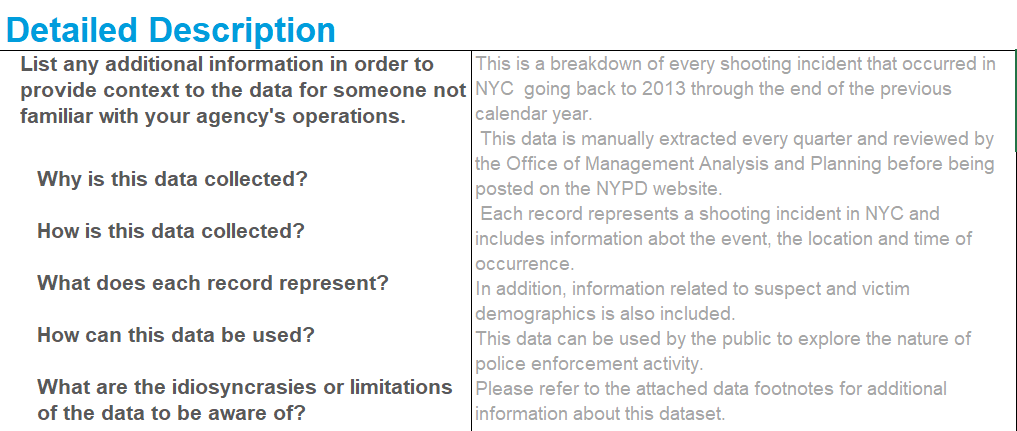

## Notes
- if a shooting has multiple victims, there are multiple rows with the same incident_id
- X and Y Coordinates are in NAD 1983 State Plane New York Long Island Zone
Feet (EPSG 2263)
- **statitistcal_murder_flag** = whether or not somebody actually died

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyproj

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
df = pd.read_csv("Shooting_data.csv")

In [ ]:
df.head(5)

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,LOC_OF_OCCUR_DESC,PRECINCT,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,...,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,228798151,05/27/2021,21:30:00,QUEENS,NaN,105,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1.058925e+06,180924.000000,40.662965,-73.730839,POINT (-73.73083868899994 40.662964620000025)
1,137471050,06/27/2014,17:40:00,BRONX,NaN,40,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1.005028e+06,234516.000000,40.810352,-73.924942,POINT (-73.92494232599995 40.81035186300006)
2,147998800,11/21/2015,03:56:00,QUEENS,NaN,108,0.0,NaN,NaN,True,...,NaN,NaN,25-44,M,WHITE,1.007668e+06,209836.531250,40.742607,-73.915492,POINT (-73.91549174199997 40.74260663300004)
3,146837977,10/09/2015,18:30:00,BRONX,NaN,44,0.0,NaN,NaN,False,...,NaN,NaN,<18,M,WHITE HISPANIC,1.006537e+06,244511.140625,40.837782,-73.919457,POINT (-73.91945661499994 40.83778200300003)
4,58921844,02/19/2009,22:58:00,BRONX,NaN,47,0.0,NaN,NaN,True,...,M,BLACK,45-64,M,BLACK,1.024922e+06,262189.406250,40.886238,-73.852910,POINT (-73.85290950899997 40.88623791800006)


## Column Properties

In [ ]:
dens = df.isna().apply(pd.value_counts).apply(lambda r: r[0] / len(df))
dens

INCIDENT_KEY               1.000000
OCCUR_DATE                 1.000000
OCCUR_TIME                 1.000000
BORO                       1.000000
LOC_OF_OCCUR_DESC          0.062830
PRECINCT                   1.000000
JURISDICTION_CODE          0.999927
LOC_CLASSFCTN_DESC         0.062830
LOCATION_DESC              0.451633
STATISTICAL_MURDER_FLAG    1.000000
PERP_AGE_GROUP             0.657879
PERP_SEX                   0.659124
PERP_RACE                  0.659124
VIC_AGE_GROUP              1.000000
VIC_SEX                    1.000000
VIC_RACE                   1.000000
X_COORD_CD                 1.000000
Y_COORD_CD                 1.000000
Latitude                   0.999634
Longitude                  0.999634
Lon_Lat                    0.999634
dtype: float64

In [ ]:
# columns with no nulls
dens[dens == 1]

INCIDENT_KEY               1.0
OCCUR_DATE                 1.0
OCCUR_TIME                 1.0
BORO                       1.0
PRECINCT                   1.0
STATISTICAL_MURDER_FLAG    1.0
VIC_AGE_GROUP              1.0
VIC_SEX                    1.0
VIC_RACE                   1.0
X_COORD_CD                 1.0
Y_COORD_CD                 1.0
dtype: float64

In [ ]:
df.X_COORD_CD.describe() # no zero-values, can assume that the data is good (same for Y but I left that out)

count    2.731200e+04
mean     1.009449e+06
std      1.837783e+04
min      9.149281e+05
25%      1.000029e+06
50%      1.007731e+06
75%      1.016838e+06
max      1.066815e+06
Name: X_COORD_CD, dtype: float64

In [ ]:
len(df.INCIDENT_KEY.value_counts()) # number of total incidents

21420

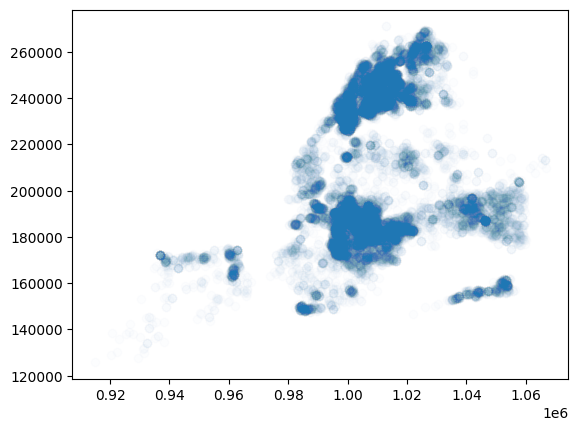

In [ ]:
# plotting locations of incidents
plt.scatter(df.X_COORD_CD, df.Y_COORD_CD, alpha=0.01) # looks like a lower density of shootings in staten island / queens
plt.savefig('locations.png', transparent=True)

for reference, the entire area covered by EPSG 2263

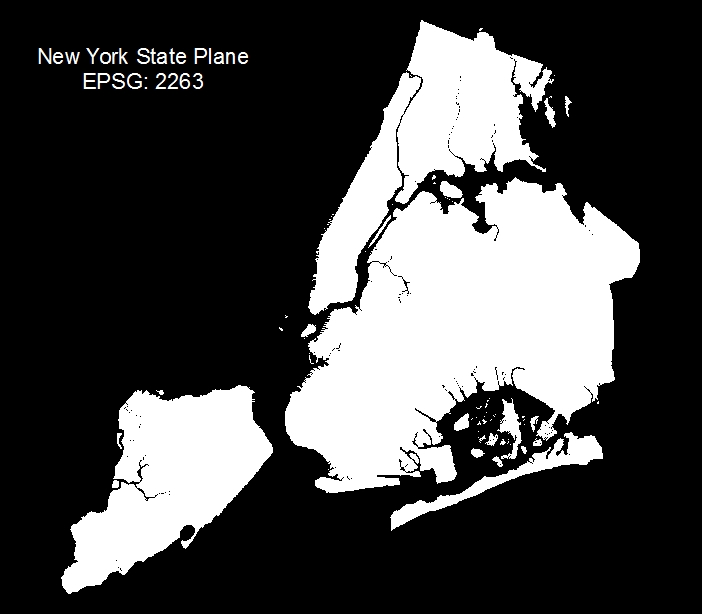

In [ ]:
# is relevant data for events with same incident ID the same?
# no: most mismatches tend to be about perpetrator attributes - could mean multiple perpatrators ?
# nothing is said about this in the data dictionary, though
# is consistent for most events, though, so maybe using mode is OK if we need to extract features about perpatrator
to_compare = ["OCCUR_TIME", "OCCUR_DATE", "BORO", "PRECINCT", "PERP_AGE_GROUP", "PERP_SEX", "PERP_RACE", "X_COORD_CD", "Y_COORD_CD"]
mismatches = []
c = 0
for key in df.INCIDENT_KEY.unique():
    rows = df[df.INCIDENT_KEY == key][to_compare]
    check = rows.apply(lambda col: len(col.value_counts()) == 1 or col.isna().all())
    if not check.all():
        mismatches.append(key)
len(mismatches)

1415

## Data Transformations

In [ ]:
# merge occur_time and occur_date into occur_datetime
with_datetime = df.copy()
with_datetime["OCCUR_DATETIME"] = pd.to_datetime(df.OCCUR_DATE) + pd.to_timedelta(df.OCCUR_TIME)
with_datetime = df.drop(["OCCUR_DATE", "OCCUR_TIME"], axis=1)

In [ ]:
# merge rows to get number of victims / deaths per incident
wd = with_datetime
merged = wd.groupby("INCIDENT_KEY").apply(lambda df: len(df))
merged.describe()

count    21420.000000
mean         1.275070
std          0.840668
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         18.000000
dtype: float64

In [ ]:
proj = pyproj.Transformer.from_crs(2263, 4326)
lat = wd.apply(lambda row: proj.transform(row.X_COORD_CD, row.Y_COORD_CD)[0], axis=1)
long = wd.apply(lambda row: proj.transform(row.X_COORD_CD, row.Y_COORD_CD)[1], axis=1)
wd["LATITUDE"] = lat
wd["LONGITUDE"] = long
wd = wd.drop(["Lon_Lat", "Longitude", "Latitude"], axis=1)

In [ ]:
wd

,INCIDENT_KEY,BORO,LOC_OF_OCCUR_DESC,PRECINCT,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,LATITUDE,LONGITUDE
0,228798151,QUEENS,NaN,105,0.0,NaN,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1.058925e+06,180924.000000,40.662956,-73.730837
1,137471050,BRONX,NaN,40,0.0,NaN,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1.005028e+06,234516.000000,40.810344,-73.924941
2,147998800,QUEENS,NaN,108,0.0,NaN,NaN,True,NaN,NaN,NaN,25-44,M,WHITE,1.007668e+06,209836.531250,40.742598,-73.915490
3,146837977,BRONX,NaN,44,0.0,NaN,NaN,False,NaN,NaN,NaN,<18,M,WHITE HISPANIC,1.006537e+06,244511.140625,40.837774,-73.919455
4,58921844,BRONX,NaN,47,0.0,NaN,NaN,True,25-44,M,BLACK,45-64,M,BLACK,1.024922e+06,262189.406250,40.886230,-73.852908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27307,245029823,BRONX,OUTSIDE,48,0.0,STREET,(null),False,(null),(null),(null),18-24,M,BLACK,1.011526e+06,247828.000000,40.846864,-73.901413
27308,239583450,MANHATTAN,OUTSIDE,30,0.0,STREET,(null),False,25-44,F,WHITE HISPANIC,25-44,M,WHITE HISPANIC,9.974580e+05,240485.000000,40.826741,-73.952275
27309,246825728,MANHATTAN,OUTSIDE,32,0.0,STREET,(null),False,18-24,M,BLACK,25-44,M,BLACK,1.000999e+06,234464.000000,40.810209,-73.939496
27310,246876579,BRONX,INSIDE,46,2.0,HOUSING,MULTI DWELL - PUBLIC HOUS,False,25-44,M,BLACK,25-44,M,WHITE HISPANIC,1.012980e+06,251028.000000,40.855642,-73.896144
